## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import datetime
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import neighbors, svm, naive_bayes,linear_model,tree,ensemble
from sklearn import metrics
import xgboost as xgb

## Read Data

In [2]:
path = "D:/python projects/read_files/supermarket_sales - Sheet1.csv"
spmSales = pd.read_csv(path)

## Data Preparation

I will prepare the data before i get into data preprocessing

In [3]:
spmSales.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
spmSales.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

In [5]:
spmSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
Invoice ID                 1000 non-null object
Branch                     1000 non-null object
City                       1000 non-null object
Customer type              1000 non-null object
Gender                     1000 non-null object
Product line               1000 non-null object
Unit price                 1000 non-null float64
Quantity                   1000 non-null int64
Tax 5%                     1000 non-null float64
Total                      1000 non-null float64
Date                       1000 non-null object
Time                       1000 non-null object
Payment                    1000 non-null object
cogs                       1000 non-null float64
gross margin percentage    1000 non-null float64
gross income               1000 non-null float64
Rating                     1000 non-null float64
dtypes: float64(7), int64(1), object(9)
memory usage: 132.9+ KB


In [6]:
spmSales.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.220360e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


#### General Column Handling

I like to do general column handling to make typings more easy and less effort, generally it's just to format date to proper data format and format column naming

In [7]:
spmSales.columns = spmSales.columns.str.replace(' ','')
spmSales.columns = spmSales.columns.str.lower()
spmSales = spmSales.drop(['invoiceid','time','tax5%','cogs','grossmarginpercentage',
                          'grossincome'],1)

In [8]:
spmSales.date = spmSales.date.str.replace('/','-')
spmSales.date = [datetime.datetime.strptime(ts,'%m-%d-%Y').strftime('%Y-%m-%d') 
                 for ts in spmSales.date]
spmSales.date = pd.to_datetime(spmSales.date)
spmSales = spmSales.sort_values(by=['date'])

In [9]:
spmSales.isnull().sum()

branch          0
city            0
customertype    0
gender          0
productline     0
unitprice       0
quantity        0
total           0
date            0
payment         0
rating          0
dtype: int64

In [10]:
spmSales.duplicated().any()

False

## Data Exploration

I will explore the data to check if there's issues that needs to be handled and to understand the data better

#### Plot General Relationship

Plotting with pairplot it gives us the insight of the distribution of each data, the variance, the correlation. Which related to homo/heteroscedasticity, distribution shapes, multicollinearity. But for multicollinearity would be easier to detect from correlation heatmap which later i will create

<Figure size 432x288 with 0 Axes>

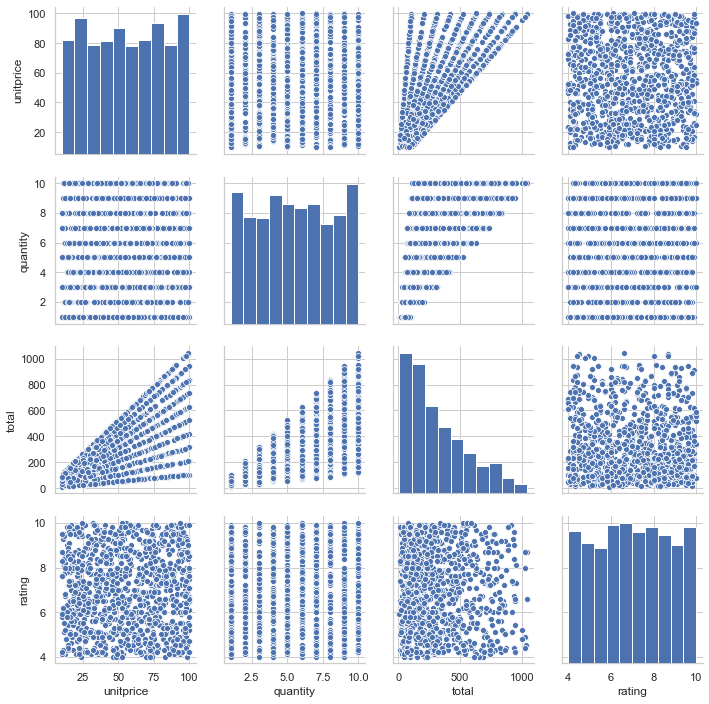

In [11]:
plt.figure()
ax = sns.pairplot(spmSales)

### Plot Correlation

I want to see correlation between features towards the target, the target is productline, and the correlation values will be sorted to easier choosing the top biggest ones

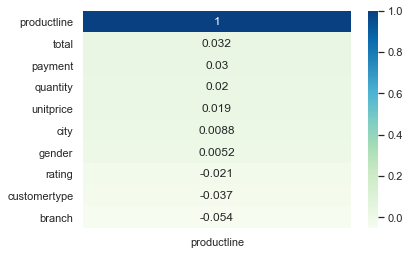

In [12]:
def encode(df):
    for column in df.columns:
        if df[column].dtype == object:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])

corrdf = spmSales.copy()
encode(corrdf)

corrtarget = corrdf[corrdf.columns[0:13]].corr()['productline'].sort_values(ascending=False)
fig, ax = plt.subplots()
sns.heatmap(corrtarget.to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")

## Feature Engineering

Since it seems that the correlations values towards the target are utterly weak, i will consider do feature engineering. Feature engineering is the process creating new input features for machine learning, is one of the most effective ways to improve predictive models. Since my target is product line which is product category in the supermarket then i'll think what makes people buy certain product line. In slightest thought people will buy what they need, so they will buy it if they need it or want it. I'll consider people will buy spesific productline in spesific time e.g in households, people will likely buy monthly stock of food and perhaps daily. So i will create new features those are month and day

In [13]:
spmSales['month'] = spmSales.date.dt.month
spmSales['day'] = spmSales.date.dt.day

In [14]:
spmSales = spmSales.reset_index(drop=True)
spmSales = spmSales.set_index(spmSales.date)
spmSales = spmSales.drop(['date'],1)

### Replot Correlation

I will replot if the new features are good enough to stand, from this plot i will choose top 4th values. Here the day feature could be use since it has 2nd biggest values in negative correlation perspective

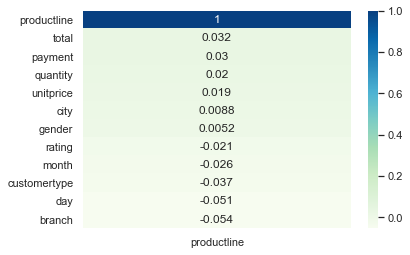

In [15]:
corrdf = spmSales.copy()
encode(corrdf)

corrtarget = corrdf[corrdf.columns[0:13]].corr()['productline'].sort_values(ascending=False)
fig, ax = plt.subplots()
sns.heatmap(corrtarget.to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")

### Plot Distributions

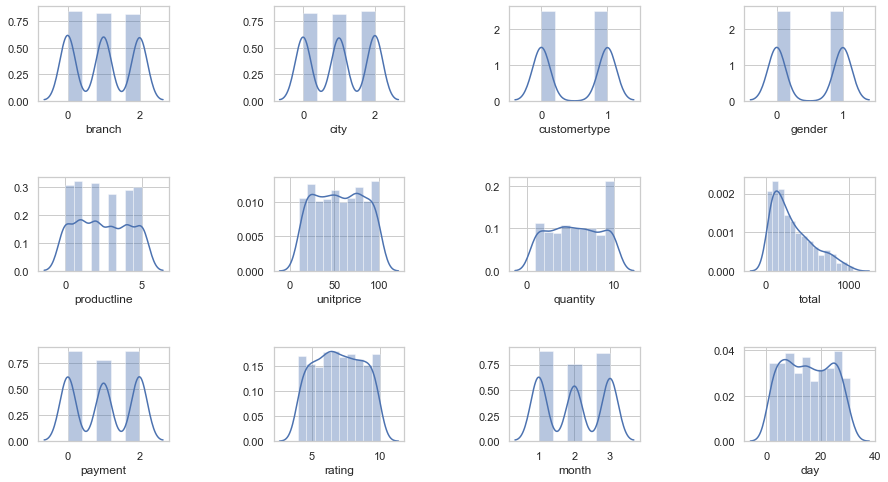

In [16]:
fig, axes = plt.subplots(3,4,figsize=(15,8))
fig.subplots_adjust(hspace=.8,wspace=.8)
for i, column in enumerate(corrdf.columns):
    sns.distplot(corrdf[column],ax=axes[i//4,i%4])

### Plot Branch Location

Most branches are in Yangon City with most branches are B,A,C

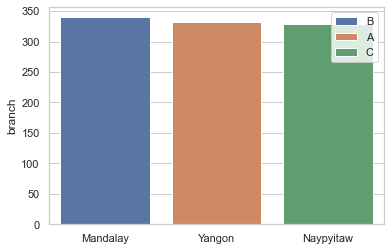

In [17]:
citybranch = spmSales.groupby(['city','branch'])['branch'].count().sort_values(ascending=False)
plt.figure()
sns.barplot(spmSales.city.unique(),citybranch,hue=spmSales.branch.unique(),dodge=False)

### Plot Total Product Sold in Branch

Most product are sold in branch B

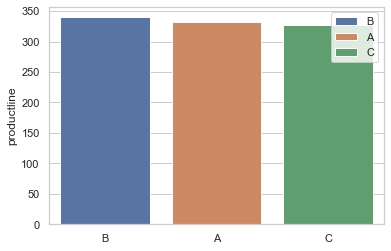

In [18]:
productsold = spmSales.groupby(['branch'])['productline'].count()
plt.figure()
sns.barplot(spmSales.branch.unique(),productsold,hue=spmSales.branch.unique(),dodge=False)

### Plot Branch Rating

Most rating are given to branch B, it makes sense that people buy more from that branch

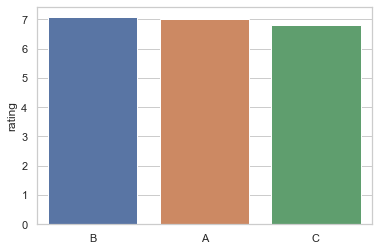

In [19]:
branchrating = spmSales.groupby(['city','branch'])['rating'].mean().sort_values(ascending=False)
plt.figure()
sns.barplot(spmSales.branch.unique(),branchrating)

### Plot Numbers of Produclines Sold

It shows that the number of productlines sold are not that different 

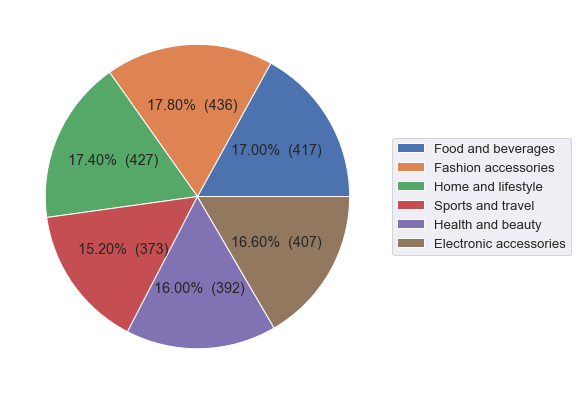

In [20]:
plt.figure(figsize=(7,7))
sns.set(font_scale=1.2)
plt.pie(corrdf.groupby(['productline'])['productline'].count(),
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(corrdf['productline'])/100))
plt.legend(spmSales['productline'].unique(),loc='center right',
            bbox_to_anchor=(1, 0, 0.5, 1))

### Plot Numbers of Produclines Sold Through Date

C:\Users\Ramadhina\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


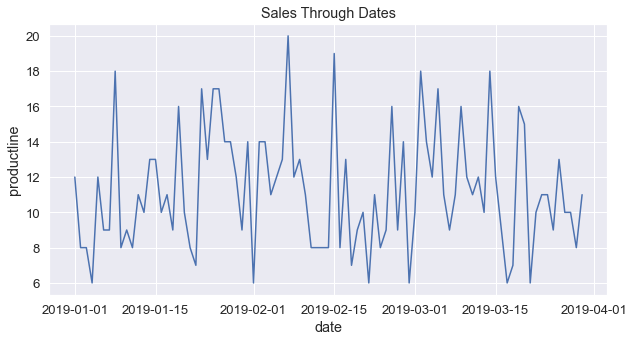

In [21]:
saled = spmSales.groupby(spmSales.index)['productline'].count()
plt.figure(figsize=(10,5))
plt.title('Sales Through Dates')
sns.lineplot(spmSales.index.unique(),saled)

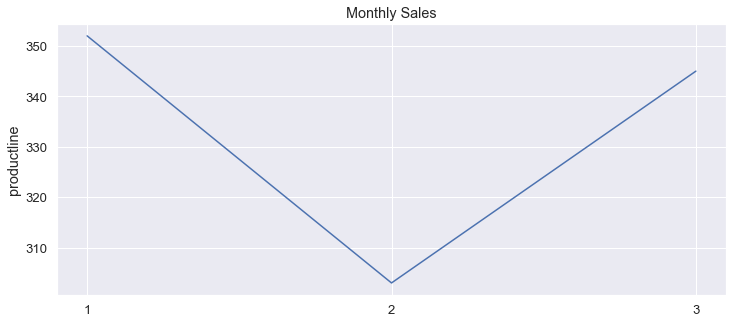

In [22]:
monthgroup = spmSales.groupby(['month'])['productline'].count()
plt.figure(figsize=(12,5))
plt.xticks(ticks=range(0,13))
plt.title('Monthly Sales')
sns.lineplot(spmSales.month.unique(),monthgroup)

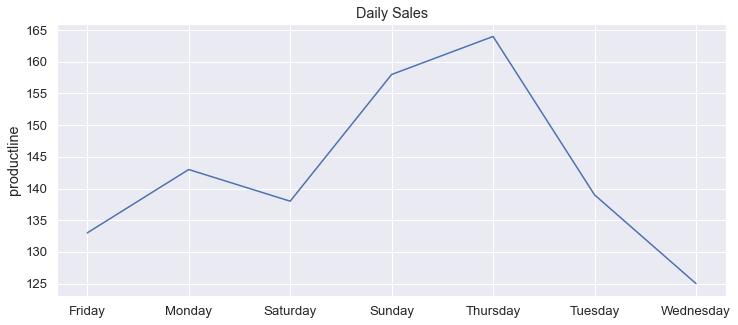

In [23]:
sp_copy = spmSales[['productline']].copy()
import calendar
sp_copy['week'] = sp_copy.index.weekday
calendar.day_name[sp_copy['week'][0]]
day = []
for row in sp_copy['week']:
    convert = calendar.day_name[row]
    day.append(convert)
sp_copy['day'] = day
sp_copy = sp_copy.reset_index(drop=True)
daygroup = sp_copy.groupby(['day'])['productline'].count()
plt.figure(figsize=(12,5))
plt.xticks(ticks=range(0,13))
plt.title('Daily Sales')
sns.lineplot(sp_copy.day.unique(),daygroup)

## Data Preprocessing

The X will only contain top 4th correlated features, and i will transform them into numerical features through one hot encoding and strandardize the features

In [24]:
X = np.array(spmSales[['branch','day','customertype','total']])
y = np.array(spmSales.productline)

In [25]:
transformerX = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0,2])],
                                remainder='passthrough')
X = transformerX.fit_transform(X)

In [26]:
scX = StandardScaler()
X = scX.fit_transform(X)

## Data Modelling

### Algorithm Selection

Choosing algorithm is a bit tricky because of underlying assumptions of each of them. Let's try to give it a shot to test which algorithm of the list of algorithms will give the maximum accuracy

In [27]:
kf = KFold(n_splits=10)

scores = []

def crossval(model):
    scores.clear()
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        scores.append(metrics.accuracy_score(y_test, y_pred))
    return (np.max(scores))

NB = naive_bayes.GaussianNB()
SVC = svm.SVC()
KNN = neighbors.KNeighborsClassifier()
LOGR = linear_model.LogisticRegression()
DT = tree.DecisionTreeClassifier()
GB = ensemble.GradientBoostingClassifier()
RF = ensemble.RandomForestClassifier()
XGB = xgb.XGBClassifier()

algorithms = [NB,SVC,KNN,LOGR,DT,GB,RF,XGB]

for a in algorithms:
    print('Max scores of default %s = %s'%(a.__class__.__name__,crossval(a)))

Max scores of default GaussianNB = 0.2
Max scores of default SVC = 0.19
Max scores of default KNeighborsClassifier = 0.19
Max scores of default LogisticRegression = 0.21
Max scores of default DecisionTreeClassifier = 0.22
Max scores of default GradientBoostingClassifier = 0.23
Max scores of default RandomForestClassifier = 0.17
Max scores of default XGBClassifier = 0.24


### Tuning Hyperparameter and Data Fitting

Since the XGBClassifier outperforms the rest of algorithms for sure, i am going to use it. To make our model more powerful i will tune the hyperparameter so i could know the best parameters and fit the model with best params

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [5, 10, 20 ,30],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10, 20, 50],
        'learning_rate': [0.01,0.02,0.1,0.3],
        'num_class' : [6]
}

grid = GridSearchCV(estimator= XGB,param_grid =params,
                    refit=True,verbose=1,cv =2,n_jobs=-1)

grid.fit(X_train,y_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  4.9min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos...d=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [5, 10, 20, 30],
                         'learning_rate': [0.01, 0.02, 0.1, 0.3],
            

## Evaluation and Best Parameter

I will make a base model to compare my model with the hyperparameter tuning to see if my model works better

In [29]:
def evaluate(model,X_train,y_train,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Training score = %s'%(model.score(X_train,y_train)))
    print('Testing score = %s'%(model.score(X_test,y_test)))
    print('Accuracy score = %s'%(accuracy))

In [30]:
best_param = grid.best_estimator_
evaluate(best_param,X_train,y_train,X_test,y_test)

Training score = 0.3725
Testing score = 0.17
Accuracy score = 0.17


#### Best parameters

Let's see the best parameters that's been fed to my model

In [31]:
print(best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=6, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6, verbosity=1)


In [32]:
XGBD = xgb.XGBClassifier()
XGBD.fit(X_train,y_train)
evaluate(XGBD,X_train,y_train,X_test,y_test)

Training score = 0.5575
Testing score = 0.18
Accuracy score = 0.18


### CONCLUSION

1. **About Feature Engineering** : I have tried feature engineering to improve the model's predictive power. It's important to remember that feature engineering by 'touching' the target is not allowed to do as it will only create more bias to the model. We could do feature engineering by brainstorming or even collect more knowledge about the target as feature engineering is considered as art in machine learning.
2. **About Model Performance** : My model's performance is still considered to be a poor model hence it's not reliable to predict the target, it could be because i only have very poor correlated features so i did not expect much from it. Also the important thing to note is that this time my model does not outperforms the base model thus the expectation i have is not met.
3. **About Target of the kernel** : The target of this kernel is to predict the product demand of supermarket and can be confidently done if the accuracy good enough
4. **Insight from data exploration** : We could see that the most product sales is fashion and accessory, with the best rating branch is branch B which all of it located in Mandalay. We could try to improve the the rating thus it could sell even more because branch which has higher rating tends to has higher product sales. And the monthly sales drops significantly in February and increase again significantly next in March, this could be the chance to do increasing since it could explain the product demand. And in Friday and Wednesday sells the fewest product, this could be use to give offer to customers in order to boost the sale.